In [12]:
# Untar the file: tar -xzf fer2013.tar 

!tar -xvzf datasets/fer2013.tar.gz

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1,2,3,6,7'

In [1]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras

from models.cnn import mini_XCEPTION
from utils.datasets import DataManager
from utils.datasets import split_data
from utils.preprocessor import preprocess_input

# parameters
batch_size = 32
num_epochs = 10000
input_shape = (64, 64, 1)
validation_split = .2
verbose = 1
num_classes = 7
patience = 50
base_path = 'trained_models/emotion_models/'

In [2]:
# data generator
data_generator = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=.1, horizontal_flip=True)

# model parameters/compilation
model = mini_XCEPTION(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


datasets = ['fer2013']
for dataset_name in datasets:
    print('Training dataset:', dataset_name)

    # callbacks
    log_file_path = base_path + dataset_name + '_emotion_training.log'
    csv_logger = CSVLogger(log_file_path, append=False)
    early_stop = EarlyStopping('val_loss', patience=patience)
    reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
    trained_models_path = base_path + dataset_name + '_mini_XCEPTION'
    model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
    model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1, save_best_only=True)
    callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

    # loading dataset
    data_loader = DataManager(dataset_name, image_size=input_shape[:2])
    faces, emotions = data_loader.get_data()
    faces = preprocess_input(faces)
    num_samples, num_classes = emotions.shape
    train_data, val_data = split_data(faces, emotions, validation_split)
    train_faces, train_emotions = train_data
    model.fit_generator(data_generator.flow(train_faces, train_emotions, batch_size), steps_per_epoch=len(train_faces) / batch_size, epochs=num_epochs, verbose=1, callbacks=callbacks, validation_data=val_data, use_multiprocessing=True, workers=40)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 62, 62, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 62, 62, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 62, 62, 8)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

FileNotFoundError: [Errno 2] No such file or directory: 'face_classification/datasets/fer2013/fer2013.csv'

In [3]:
model_names

'face_classification/trained_models/emotion_models/fer2013_mini_XCEPTION.{epoch:02d}-{val_accuracy:.2f}.hdf5'

In [4]:
!ls -al trained_models/emotion_models/fer2013_mini_XCEPTION*.hdf5

-rw-r--r-- 1 ankur ankur 872856 Jul 17 03:54 face_classification/trained_models/emotion_models/fer2013_mini_XCEPTION.00-0.47.hdf5
-rw-r--r-- 1 ankur ankur 969880 Jul 17 05:02 face_classification/trained_models/emotion_models/fer2013_mini_XCEPTION.01-0.36.hdf5
-rw-r--r-- 1 ankur ankur 872856 Jul 17 03:54 face_classification/trained_models/emotion_models/fer2013_mini_XCEPTION.02-0.52.hdf5
-rw-r--r-- 1 ankur ankur 872856 Jul 17 03:54 face_classification/trained_models/emotion_models/fer2013_mini_XCEPTION.03-0.53.hdf5
-rw-r--r-- 1 ankur ankur 872856 Jul 17 03:54 face_classification/trained_models/emotion_models/fer2013_mini_XCEPTION.04-0.55.hdf5
-rw-r--r-- 1 ankur ankur 872856 Jul 17 03:54 face_classification/trained_models/emotion_models/fer2013_mini_XCEPTION.05-0.56.hdf5
-rw-r--r-- 1 ankur ankur 872856 Jul 17 03:54 face_classification/trained_models/emotion_models/fer2013_mini_XCEPTION.08-0.57.hdf5
-rw-r--r-- 1 ankur ankur 872856 Jul 17 03:54 face_classification/trained_models/emotion_mo

In [ ]:
emotion_model_path = 'trained_models/emotion_models/fer2013_mini_XCEPTION.99-0.65.hdf5'
emotion_classifier = load_model(emotion_model_path, compile=False)
emotion_classifier.summary()

## Testing Trained model

In [9]:
import sys

import cv2
from tensorflow.keras.models import load_model
import numpy as np

from utils.datasets import get_labels
from utils.inference import detect_faces
from utils.inference import draw_text
from utils.inference import draw_bounding_box
from utils.inference import apply_offsets
from utils.inference import load_detection_model
from utils.inference import load_image
from utils.preprocessor import preprocess_input
import matplotlib.pyplot as plt

# parameters for loading data and images
image_path = 'images/c.jpg'
detection_model_path = 'trained_models/detection_models/haarcascade_frontalface_default.xml'
emotion_model_path = 'trained_models/emotion_models/fer2013_mini_XCEPTION.99-0.65.hdf5'
gender_model_path = 'trained_models/gender_models/simple_CNN.81-0.96.hdf5'
emotion_labels = get_labels('fer2013')
gender_labels = get_labels('imdb')
font = cv2.FONT_HERSHEY_SIMPLEX

In [10]:
# hyper-parameters for bounding boxes shape
gender_offsets = (30, 60)
gender_offsets = (10, 10)
emotion_offsets = (20, 40)
emotion_offsets = (0, 0)

# loading models
face_detection = load_detection_model(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
gender_classifier = load_model(gender_model_path, compile=False)

# getting input model shapes for inference
emotion_target_size = emotion_classifier.input_shape[1:3]
gender_target_size = gender_classifier.input_shape[1:3]

# loading images
rgb_image = load_image(image_path, grayscale=False, color_mode="rgb")
gray_image = load_image(image_path, grayscale=True, color_mode="grayscale")
gray_image = np.squeeze(gray_image)
gray_image = gray_image.astype('uint8')

faces = detect_faces(face_detection, gray_image)
for face_coordinates in faces:
    x1, x2, y1, y2 = apply_offsets(face_coordinates, gender_offsets)
    rgb_face = rgb_image[y1:y2, x1:x2]

    x1, x2, y1, y2 = apply_offsets(face_coordinates, emotion_offsets)
    gray_face = gray_image[y1:y2, x1:x2]

    try:
        rgb_face = cv2.resize(rgb_face, (gender_target_size))
        gray_face = cv2.resize(gray_face, (emotion_target_size))
    except:
        continue

    rgb_face = preprocess_input(rgb_face, False)
    rgb_face = np.expand_dims(rgb_face, 0)
    gender_prediction = gender_classifier.predict(rgb_face)
    gender_label_arg = np.argmax(gender_prediction)
    gender_text = gender_labels[gender_label_arg]

    gray_face = preprocess_input(gray_face, True)
    gray_face = np.expand_dims(gray_face, 0)
    gray_face = np.expand_dims(gray_face, -1)
    emotion_label_arg = np.argmax(emotion_classifier.predict(gray_face))
    emotion_text = emotion_labels[emotion_label_arg]

    if gender_text == gender_labels[0]:
        color = (0, 0, 255)
    else:
        color = (255, 0, 0)

    draw_bounding_box(face_coordinates, rgb_image, color)
    draw_text(face_coordinates, rgb_image, gender_text, color, 0, -20, 1, 2)
    draw_text(face_coordinates, rgb_image, emotion_text, color, 0, -50, 1, 2)

bgr_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
# plt.imshow(bgr_image)
cv2.imwrite('images/trained_model_test.png', bgr_image)

True

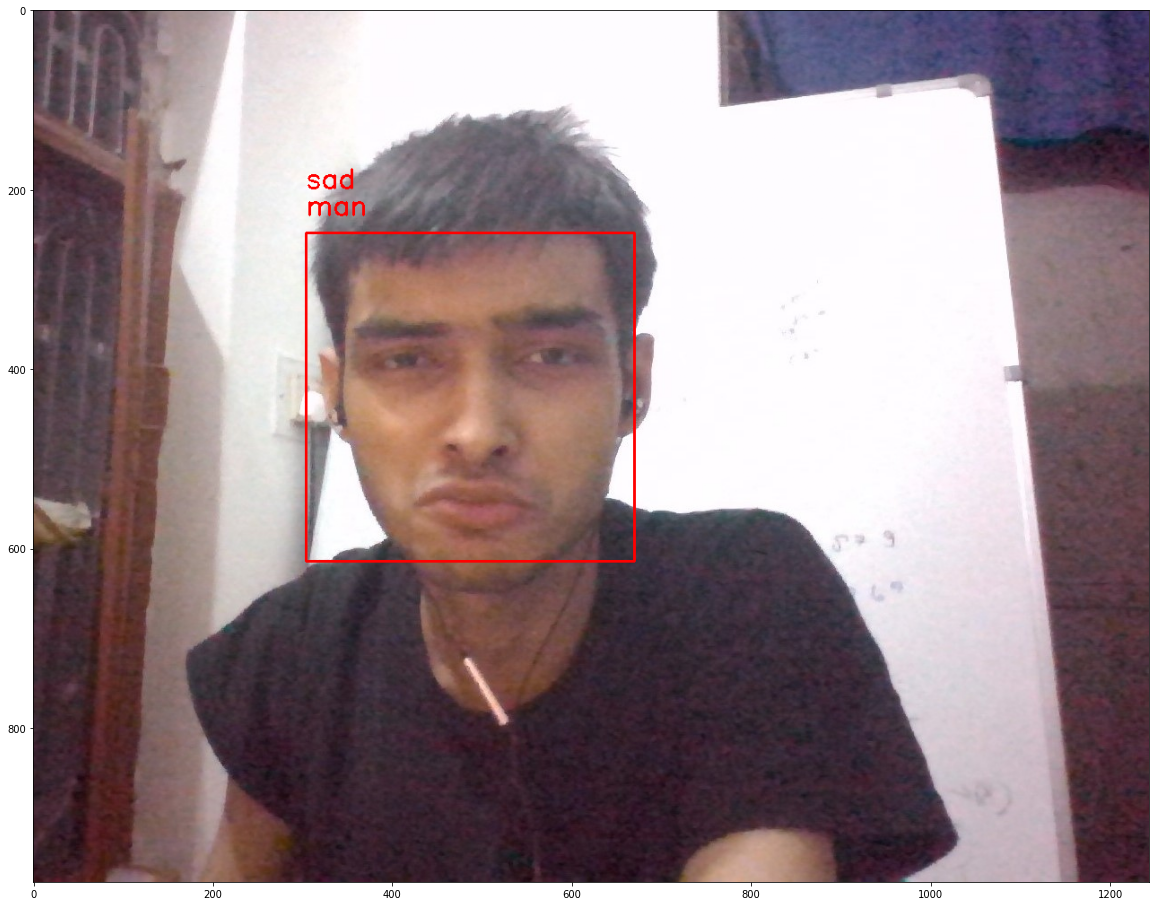

In [11]:
# default haar
img = plt.imread('images/trained_model_test.png')
fig = plt.figure(figsize=(20, 20))
plt.imshow(img)